### Import needed libraries

In [1]:
import numpy as np 
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import concatenate
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam, Adagrad, RMSprop
from keras.utils import np_utils
from keras import backend as K
from tensorflow.keras.utils import to_categorical, plot_model

from keras.models import Model
from keras.layers import Input, Dense

from keras.models import load_model
import tensorflow as tf

import matplotlib.pyplot as plt
from pathlib import Path
import os

from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns

In [2]:
data_fer = pd.read_csv('/content/drive/My Drive/Final_Term_Project_Eloise_Jin/fer2013.csv')

In [3]:
# Create variables to save net weights, loss and accuracy images

weights_path = './weights.h5'
loss_img_name = 'loss.png'
accuracy_img_name = 'accuracy.png'

In [4]:
# File with the parameters of the network

weights_file = Path(weights_path)

In [5]:
# Fix random seed for reproducibility

seed = 7
np.random.seed(seed)

### Config GPU RAM

In [6]:
config = tf.compat.v1.ConfigProto()

## ask for GPU memory gracefully
config.gpu_options.allow_growth = True

sess = tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(sess)

### Load data and prepare it for the training process

In [7]:
idx_to_emotion_fer = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

In [8]:
# Converting strings of pixels to arrays

X_fer_train, y_fer_train = np.rollaxis(data_fer[data_fer.Usage == "Training"][["pixels", "emotion"]].values, -1)
X_fer_train = np.array([np.fromstring(x, dtype="uint8", sep=" ") for x in X_fer_train]).reshape((-1, 48, 48))
y_fer_train = y_fer_train.astype('int8')

X_fer_test_public, y_fer_test_public = np.rollaxis(data_fer[data_fer.Usage == "PublicTest"][["pixels", "emotion"]].values, -1)
X_fer_test_public = np.array([np.fromstring(x, dtype="uint8", sep=" ") for x in X_fer_test_public]).reshape((-1, 48, 48))
y_fer_test_public = y_fer_test_public.astype('int8')

X_fer_test_private, y_fer_test_private = np.rollaxis(data_fer[data_fer.Usage == "PrivateTest"][["pixels", "emotion"]].values, -1)
X_fer_test_private = np.array([np.fromstring(x, dtype="uint8", sep=" ") for x in X_fer_test_private]).reshape((-1, 48, 48))
y_fer_test_private = y_fer_test_private.astype('int8')

In [9]:
X_train = X_fer_train.reshape((-1, 48, 48, 1))
X_val = X_fer_test_public.reshape((-1, 48, 48, 1))
X_test = X_fer_test_private.reshape((-1, 48, 48, 1))
y_train = to_categorical(y_fer_train,7)
y_val = to_categorical(y_fer_test_public,7)
y_test = to_categorical(y_fer_test_private,7)

BATCH_SIZE = 128

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
)

train_datagen.fit(X_train)
val_datagen.fit(X_train)

train_flow = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_flow = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)
test_flow = val_datagen.flow(X_test, y_test, batch_size=1, shuffle=False)

# Normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

print("num_training_samples: ", X_train.shape)

num_training_samples:  (28709, 48, 48, 1)


## Single Layer Perceptron

In [10]:
# Output dimension (number of emotions in our problem)
num_classes = 7 

model = Sequential() 
model.add(Flatten(input_shape=(48,48,1))) 
model.add(Dense(num_classes,activation="softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 16135     
Total params: 16,135
Trainable params: 16,135
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
epochs = 20
lrate = 0.01
decay = 0

sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Fit the model

In [12]:
epochs = 20

history = model.fit_generator(train_flow, steps_per_epoch= X_train.shape[0] // BATCH_SIZE, epochs=epochs,
  validation_data=val_flow, validation_steps = X_val.shape[0] // BATCH_SIZE, )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
224/224 [==============================] - 11s 41ms/step - loss: 332.0184 - accuracy: 0.1689 - val_loss: 134.4505 - val_accuracy: 0.1961
Epoch 2/20
224/224 [==============================] - 9s 39ms/step - loss: 261.2691 - accuracy: 0.1876 - val_loss: 175.5764 - val_accuracy: 0.1881
Epoch 3/20
224/224 [==============================] - 9s 38ms/step - loss: 259.7907 - accuracy: 0.1871 - val_loss: 401.3534 - val_accuracy: 0.2494
Epoch 4/20
224/224 [==============================] - 9s 38ms/step - loss: 274.6343 - accuracy: 0.1915 - val_loss: 266.1374 - val_accuracy: 0.2645
Epoch 5/20
224/224 [==============================] - 9s 39ms/step - loss: 260.9014 - accuracy: 0.1951 - val_loss: 165.0415 - val_accuracy: 0.2028
Epoch 6/20
224/224 [==============================] - 9s 39ms/step - loss: 272.2030 - accuracy: 0.1847 - val_loss: 346.5310 - val_accuracy: 0.1814
Epoch 7/20
224/224 [==============================] - 9s 39ms/step - loss: 275.1254 - accuracy: 0.1932 - val_loss: 26

### Plot history for accuracy for training and testing process

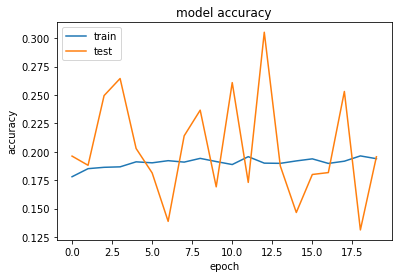

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig(accuracy_img_name)

# Show figure
plt.show()

### Plot history for loss for training and testing process

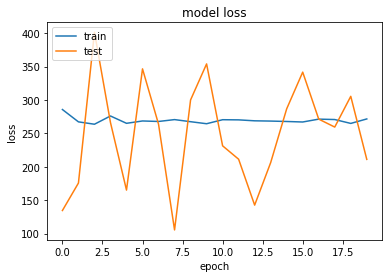

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig(loss_img_name)

# Show figure
plt.show()

In [15]:
model.save_weights(weights_path)

In [16]:
def evaluate_model(weights_path):
  model.load_weights(weights_path)
  y_pred = model.predict_generator(test_flow, steps=X_test.shape[0]) 
  y_pred_cat = np.argmax(y_pred, axis=1)
  y_true_cat = np.argmax(test_flow.y, axis=1)
  conf = confusion_matrix(y_true_cat, y_pred_cat, normalize="true")
  labels = idx_to_emotion_fer.values()
  _, ax = plt.subplots(figsize=(8, 6))
  ax = sns.heatmap(conf, annot=True, cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
                   
plt.show()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


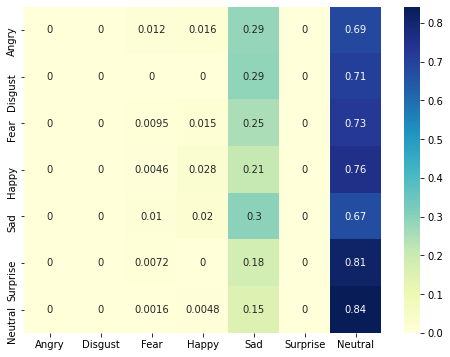

In [17]:
evaluate_model(weights_path)

## Multi Layer Perceptron

In [18]:
# Creating the model using the Sequential API

# Output dimension (number of emotions in our problem)
num_classes = 7 

# Feedforward
model = Sequential()
model.add(Flatten(input_shape=(48,48,1)))
model.add(Dense(512,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(num_classes,activation="softmax"))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1180160   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 7)                

### Initialize training parameters

In [19]:
epochs = 20
lrate = 0.01
decay = 0

sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
rmsprop = tf.keras.optimizers.RMSprop(lrate,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False,name="RMSprop")

adamop = tf.keras.optimizers.Adam(lrate)
adagop = tf.keras.optimizers.Adagrad(lrate)

model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1180160   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 7)                

### Fit the model

In [20]:
history = model.fit_generator(train_flow, 
        steps_per_epoch= X_train.shape[0] // BATCH_SIZE,
        epochs=epochs, 
        validation_data=val_flow,
        validation_steps = X_val.shape[0] // BATCH_SIZE
        )

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


224/224 [==============================] - 10s 40ms/step - loss: 8320.7705 - accuracy: 0.1847 - val_loss: 1.8164 - val_accuracy: 0.2494
Epoch 2/20
224/224 [==============================] - 9s 40ms/step - loss: 39.4641 - accuracy: 0.2321 - val_loss: 1.8164 - val_accuracy: 0.2497
Epoch 3/20
224/224 [==============================] - 9s 40ms/step - loss: 3.2969 - accuracy: 0.2452 - val_loss: 1.8140 - val_accuracy: 0.2494
Epoch 4/20
224/224 [==============================] - 9s 40ms/step - loss: 2.3894 - accuracy: 0.2491 - val_loss: 1.8130 - val_accuracy: 0.2494
Epoch 5/20
224/224 [==============================] - 9s 40ms/step - loss: 2.5730 - accuracy: 0.2468 - val_loss: 1.8150 - val_accuracy: 0.2494
Epoch 6/20
224/224 [==============================] - 9s 40ms/step - loss: 1.9739 - accuracy: 0.2458 - val_loss: 1.8139 - val_accuracy: 0.2494
Epoch 7/20
224/224 [==============================] - 9s 40ms/step - loss: 1.8297 - accuracy: 0.2517 - val_loss: 1.8120 - val_accuracy: 0.2494
Epoch

### Plot history for accuracy for training and testing process

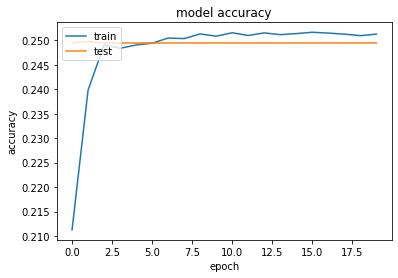

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig(accuracy_img_name)

# Show figure
plt.show()

### Plot history for loss for training and testing process

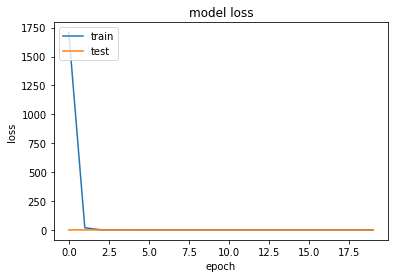

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig(loss_img_name)

# Show figure
plt.show()

### Save the weights to a file

In [23]:
model.save_weights(weights_path)

In [24]:
def evaluate_model(weights_path):
    model.load_weights(weights_path)
    y_pred = model.predict_generator(test_flow, steps=X_test.shape[0])
    y_pred_cat = np.argmax(y_pred, axis=1)
    y_true_cat = np.argmax(test_flow.y, axis=1)
    
    report = classification_report(y_true_cat, y_pred_cat)
    print(report)

    conf = confusion_matrix(y_true_cat, y_pred_cat, normalize="true")

    labels = idx_to_emotion_fer.values()
    _, ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(conf, annot=True, cmap='YlGnBu', 
                     xticklabels=labels, 
                     yticklabels=labels)

    plt.show()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       491
           1       0.00      0.00      0.00        55
           2       0.00      0.00      0.00       528
           3       0.24      1.00      0.39       879
           4       0.00      0.00      0.00       594
           5       0.00      0.00      0.00       416
           6       0.00      0.00      0.00       626

    accuracy                           0.24      3589
   macro avg       0.03      0.14      0.06      3589
weighted avg       0.06      0.24      0.10      3589



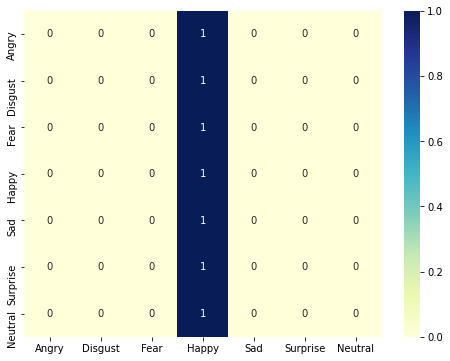

In [25]:
evaluate_model(weights_path)